In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pharma-sales-data/salesdaily.csv
/kaggle/input/pharma-sales-data/salesweekly.csv
/kaggle/input/pharma-sales-data/salesmonthly.csv
/kaggle/input/pharma-sales-data/saleshourly.csv


In [7]:
#EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

np.random.seed(42)

data_path = '/kaggle/input/pharma-sales-data/salesdaily.csv'  
df = pd.read_csv(data_path)

print(df.head())

print(f"Dataset shape: {df.shape}")

print(df.dtypes)

print(df.isnull().sum())

print(df.describe())

      datum  M01AB  M01AE  N02BA  N02BE  N05B  N05C   R03  R06  Year  Month  \
0  1/2/2014    0.0   3.67    3.4  32.40   7.0   0.0   0.0  2.0  2014      1   
1  1/3/2014    8.0   4.00    4.4  50.60  16.0   0.0  20.0  4.0  2014      1   
2  1/4/2014    2.0   1.00    6.5  61.85  10.0   0.0   9.0  1.0  2014      1   
3  1/5/2014    4.0   3.00    7.0  41.10   8.0   0.0   3.0  0.0  2014      1   
4  1/6/2014    5.0   1.00    4.5  21.70  16.0   2.0   6.0  2.0  2014      1   

   Hour Weekday Name  
0   248     Thursday  
1   276       Friday  
2   276     Saturday  
3   276       Sunday  
4   276       Monday  
Dataset shape: (2106, 13)
datum            object
M01AB           float64
M01AE           float64
N02BA           float64
N02BE           float64
N05B            float64
N05C            float64
R03             float64
R06             float64
Year              int64
Month             int64
Hour              int64
Weekday Name     object
dtype: object
datum           0
M01AB           0

In [8]:
#preprocessing

from sklearn.model_selection import train_test_split
from typing import Tuple

np.random.seed(42)

data_path = '/kaggle/input/pharma-sales-data/salesdaily.csv'
df = pd.read_csv(data_path)

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the pharma sales data: convert dates, drop unnecessary columns, resample to monthly.
    
    Args:
        df (pd.DataFrame): Raw dataframe.
    
    Returns:
        pd.DataFrame: Processed monthly dataframe.
    """
    try:
        df['datum'] = pd.to_datetime(df['datum'], format='%m/%d/%Y')
        
        df.set_index('datum', inplace=True)
        
        columns_to_drop = ['Hour', 'Year', 'Month', 'Weekday Name']  
        df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
        
        sales_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
        
        df_monthly = df[sales_columns].resample('ME').sum()
        
        df_monthly.fillna(0, inplace=True)
        
        return df_monthly
    
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return pd.DataFrame()

df_processed = preprocess_data(df)
print("Processed Monthly Data Shape:", df_processed.shape)
print(df_processed.head())

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add lag features and moving averages for time series forecasting.
    
    Args:
        df (pd.DataFrame): Monthly dataframe.
    
    Returns:
        pd.DataFrame: Dataframe with added features.
    """
    sales_columns = df.columns
    for col in sales_columns:
        
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_ma3'] = df[col].rolling(window=3).mean()
    
    df.dropna(inplace=True)
    return df

df_featured = engineer_features(df_processed)
print("Featured Data Shape:", df_featured.shape)
print(df_featured.head())

def split_data(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split time series data chronologically.
    
    Args:
        df (pd.DataFrame): Featured dataframe.
        test_size (float): Proportion for test set.
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Train and test sets.
    """
    split_index = int(len(df) * (1 - test_size))
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]
    return train, test

train_df, test_df = split_data(df_featured)
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

train_df.to_csv('/kaggle/working/train_processed.csv', index=True)
test_df.to_csv('/kaggle/working/test_processed.csv', index=True)

Processed Monthly Data Shape: (70, 8)
             M01AB    M01AE    N02BA     N02BE   N05B  N05C    R03    R06
datum                                                                    
2014-01-31  127.69   99.090  152.100   878.030  354.0  30.0  112.0   48.2
2014-02-28  133.32  126.050  177.000  1001.900  347.0  31.0  122.0   36.2
2014-03-31  137.44   92.950  147.655   779.275  232.0  20.0  112.0   85.4
2014-04-30  113.10   89.475  125.150   698.500  209.0  18.0   97.0   73.7
2014-05-31  101.79  119.933  132.100   628.780  270.0  23.0  107.0  123.7
Featured Data Shape: (68, 24)
             M01AB    M01AE    N02BA    N02BE   N05B  N05C    R03    R06  \
datum                                                                      
2014-03-31  137.44   92.950  147.655  779.275  232.0  20.0  112.0   85.4   
2014-04-30  113.10   89.475  125.150  698.500  209.0  18.0   97.0   73.7   
2014-05-31  101.79  119.933  132.100  628.780  270.0  23.0  107.0  123.7   
2014-06-30  112.07   94.710  122.9

In [9]:
#modeling

from prophet import Prophet
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Dict
import joblib 
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Load processed data from previous notebook
train_path = '/kaggle/working/train_processed.csv'
test_path = '/kaggle/working/test_processed.csv'
train_df = pd.read_csv(train_path, index_col='datum', parse_dates=['datum'])
test_df = pd.read_csv(test_path, index_col='datum', parse_dates=['datum'])

# Sales columns (original targets)
sales_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Function for baseline model: Prophet on one series (e.g., N02BE)
def baseline_prophet(train: pd.DataFrame, test: pd.DataFrame, target: str = 'N02BE') -> Dict:
    """
    Baseline forecasting with Prophet for a single series.
    
    Args:
        train (pd.DataFrame): Training data.
        test (pd.DataFrame): Test data.
        target (str): Target column to forecast.
    
    Returns:
        Dict: Metrics and forecast.
    """
    # Prepare data for Prophet (ds, y)
    prophet_train = train[[target]].reset_index().rename(columns={'datum': 'ds', target: 'y'})
    
    # Initialize and fit model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False)  # Monthly data, no weekly
    model.fit(prophet_train)
    
    # Forecast on test period
    future = model.make_future_dataframe(periods=len(test), freq='ME')
    forecast = model.predict(future)
    forecast_test = forecast.iloc[-len(test):]['yhat'].values
    
    # Metrics
    y_true = test[target].values
    mae = mean_absolute_error(y_true, forecast_test)
    rmse = np.sqrt(mean_squared_error(y_true, forecast_test))
    
    logging.info(f"Baseline Prophet for {target}: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    # Save model
    joblib.dump(model, f'/kaggle/working/prophet_{target}.pkl')
    
    return {'mae': mae, 'rmse': rmse, 'forecast': forecast_test}

# Run baseline
baseline_results = baseline_prophet(train_df, test_df, 'N02BE')
print("Baseline Results:", baseline_results)

# Function for advanced model: XGBoost with Optuna tuning for multi-series
def advanced_xgboost(train: pd.DataFrame, test: pd.DataFrame, target: str = 'N02BE') -> Dict:
    """
    Advanced forecasting with XGBoost and Optuna hyperparameter tuning.
    
    Args:
        train (pd.DataFrame): Training data.
        test (pd.DataFrame): Test data.
        target (str): Target column.
    
    Returns:
        Dict: Best params, metrics, and forecast.
    """
    # Features: all except sales_columns except target
    features = [col for col in train.columns if col != target and col not in sales_columns]
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # Optuna objective
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': 42
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_absolute_error(y_test, preds)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)  
    
    best_params = study.best_params
    best_model = xgb.XGBRegressor(**best_params)
    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    logging.info(f"XGBoost for {target}: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    joblib.dump(best_model, f'/kaggle/working/xgboost_{target}.pkl')
    
    return {'best_params': best_params, 'mae': mae, 'rmse': rmse, 'forecast': preds}

advanced_results = advanced_xgboost(train_df, test_df, 'N02BE')
print("Advanced Results:", advanced_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpna8rbu1l/j4ybm4vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpna8rbu1l/7wn3h7jm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56580', 'data', 'file=/tmp/tmpna8rbu1l/j4ybm4vc.json', 'init=/tmp/tmpna8rbu1l/7wn3h7jm.json', 'output', 'file=/tmp/tmpna8rbu1l/prophet_modelwjb2yez7/prophet_model-20260104203145.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:31:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:root:Baseline Prophet for N02BE: MAE=184.73, RMSE=325.84
[I 2026-01-04 20:31:45,881] A new study created in memory with name: no-name-8f

Baseline Results: {'mae': 184.73216658863822, 'rmse': 325.83795531418014, 'forecast': array([ 912.04172561, 1368.49589034, 1015.83423097, 1198.27226319,
       1302.5397319 , 1042.44188781,  972.97805025,  829.81793803,
        655.03918268,  632.67759048,  663.23340915,  740.05732863,
        851.43040583, 1377.4333158 ])}


[I 2026-01-04 20:31:46,090] Trial 2 finished with value: 169.44174863978793 and parameters: {'n_estimators': 116, 'max_depth': 3, 'learning_rate': 0.17526988041479885, 'subsample': 0.9792380937609207}. Best is trial 0 with value: 168.65929537527902.
[I 2026-01-04 20:31:46,166] Trial 3 finished with value: 192.93739770507813 and parameters: {'n_estimators': 112, 'max_depth': 9, 'learning_rate': 0.23836151714349094, 'subsample': 0.725272940390822}. Best is trial 0 with value: 168.65929537527902.
[I 2026-01-04 20:31:46,253] Trial 4 finished with value: 174.8798284737723 and parameters: {'n_estimators': 121, 'max_depth': 10, 'learning_rate': 0.06110580382199488, 'subsample': 0.8649386757203255}. Best is trial 0 with value: 168.65929537527902.
[I 2026-01-04 20:31:46,275] Trial 5 finished with value: 175.53096205357141 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2906743719348756, 'subsample': 0.9998936367862844}. Best is trial 0 with value: 168.65929537527902.
[I 

Advanced Results: {'best_params': {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.15337424857385468, 'subsample': 0.802118597035969}, 'mae': 175.87522823660714, 'rmse': 216.8051190223358, 'forecast': array([ 846.0667 ,  886.55255, 1059.2802 , 1093.3732 , 1228.8235 ,
        967.0556 , 1091.8761 ,  848.70386,  559.0258 ,  634.4773 ,
        569.9832 ,  619.24023,  733.33765,  727.96576], dtype=float32)}


In [10]:
#modeling

logging.basicConfig(level=logging.INFO)

train_path = '/kaggle/working/train_processed.csv'
test_path = '/kaggle/working/test_processed.csv'
train_df = pd.read_csv(train_path, index_col='datum', parse_dates=['datum'])
test_df = pd.read_csv(test_path, index_col='datum', parse_dates=['datum'])

sales_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

def baseline_prophet(train: pd.DataFrame, test: pd.DataFrame, target: str = 'N02BE') -> Dict:
    """
    Baseline forecasting with Prophet for a single series.
    
    Args:
        train (pd.DataFrame): Training data.
        test (pd.DataFrame): Test data.
        target (str): Target column to forecast.
    
    Returns:
        Dict: Metrics and forecast.
    """
    prophet_train = train[[target]].reset_index().rename(columns={'datum': 'ds', target: 'y'})
    
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  
    model.fit(prophet_train)
    
    future = model.make_future_dataframe(periods=len(test), freq='ME')
    forecast = model.predict(future)
    forecast_test = forecast.iloc[-len(test):]['yhat'].values
    
    y_true = test[target].values
    mae = mean_absolute_error(y_true, forecast_test)
    rmse = np.sqrt(mean_squared_error(y_true, forecast_test))
    
    logging.info(f"Baseline Prophet for {target}: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    joblib.dump(model, f'/kaggle/working/prophet_{target}.pkl')
    
    return {'mae': mae, 'rmse': rmse, 'forecast': forecast_test}

baseline_results = baseline_prophet(train_df, test_df, 'N02BE')
print("Baseline Results:", baseline_results)

def advanced_xgboost(train: pd.DataFrame, test: pd.DataFrame, target: str = 'N02BE') -> Dict:
    """
    Advanced forecasting with XGBoost and Optuna hyperparameter tuning.
    
    Args:
        train (pd.DataFrame): Training data.
        test (pd.DataFrame): Test data.
        target (str): Target column.
    
    Returns:
        Dict: Best params, metrics, and forecast.
    """
    features = [col for col in train.columns if col != target and col not in sales_columns]
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': 42
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_absolute_error(y_test, preds)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)  
    
    best_params = study.best_params
    best_params['random_state'] = 42  
    best_model = xgb.XGBRegressor(**best_params)
    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    logging.info(f"XGBoost for {target}: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    
    joblib.dump(best_model, f'/kaggle/working/xgboost_{target}.pkl')
    
    return {'best_params': best_params, 'mae': mae, 'rmse': rmse, 'forecast': preds}

advanced_results = advanced_xgboost(train_df, test_df, 'N02BE')
print("Advanced Results:", advanced_results)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpna8rbu1l/qs2ex13c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpna8rbu1l/tfm3drtd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97283', 'data', 'file=/tmp/tmpna8rbu1l/qs2ex13c.json', 'init=/tmp/tmpna8rbu1l/tfm3drtd.json', 'output', 'file=/tmp/tmpna8rbu1l/prophet_model9smxeczh/prophet_model-20260104203416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:34:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:34:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:root:Baseline Prophet for N02BE: MAE=313.74, RMSE=434.05
[I 2026-01-04 20:34:17,180] A new study created in memory with name: no-name-38934556-ac98-455c-a176-460ff0ffbcaf
[I 2026-01-04 20:34:17,287] Trial 0 finished with value: 165.0313

Baseline Results: {'mae': 313.74216874842404, 'rmse': 434.05260761364957, 'forecast': array([ 825.24933206, 1200.65750149,  925.19127509, 1031.05928113,
       1224.64652376,  447.1227695 ,  988.10190374,  219.2019375 ,
        678.68548586,   17.6992989 ,  672.93683073,  885.23220603,
        807.66391284, 1451.35373712])}


[I 2026-01-04 20:34:17,409] Trial 2 finished with value: 172.7979149344308 and parameters: {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.04010580628086435, 'subsample': 0.9630172585941937}. Best is trial 0 with value: 165.031361328125.
[I 2026-01-04 20:34:17,469] Trial 3 finished with value: 173.46642689732144 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.014600789057538838, 'subsample': 0.6897706106370192}. Best is trial 0 with value: 165.031361328125.
[I 2026-01-04 20:34:17,567] Trial 4 finished with value: 163.7950934361049 and parameters: {'n_estimators': 148, 'max_depth': 10, 'learning_rate': 0.14596234723720541, 'subsample': 0.6224196960294996}. Best is trial 4 with value: 163.7950934361049.
[I 2026-01-04 20:34:17,653] Trial 5 finished with value: 169.79500268554688 and parameters: {'n_estimators': 141, 'max_depth': 8, 'learning_rate': 0.03663297177771848, 'subsample': 0.7934065093849456}. Best is trial 4 with value: 163.7950934361049.
[I 202

Advanced Results: {'best_params': {'n_estimators': 148, 'max_depth': 10, 'learning_rate': 0.14596234723720541, 'subsample': 0.6224196960294996, 'random_state': 42}, 'mae': 163.7950934361049, 'rmse': 208.06398417069693, 'forecast': array([ 789.416  ,  889.5165 , 1129.7302 , 1167.8433 , 1372.399  ,
        998.85284, 1117.5371 ,  782.06024,  620.9177 ,  638.309  ,
        539.8397 ,  551.2873 ,  652.1046 ,  740.1691 ], dtype=float32)}


              actual  prophet_pred  xgboost_pred
datum                                           
2018-09-30  1058.262    825.249332    789.416016
2018-10-31  1129.275   1200.657501    889.516479
2018-11-30   995.150    925.191275   1129.730225
2018-12-31  1213.950   1031.059281   1167.843262
2019-01-31  1660.612   1224.646524   1372.399048
Metrics Table:
      Model         MAE        RMSE
0  Prophet  313.742169  434.052608
1  XGBoost  163.795093  208.063984


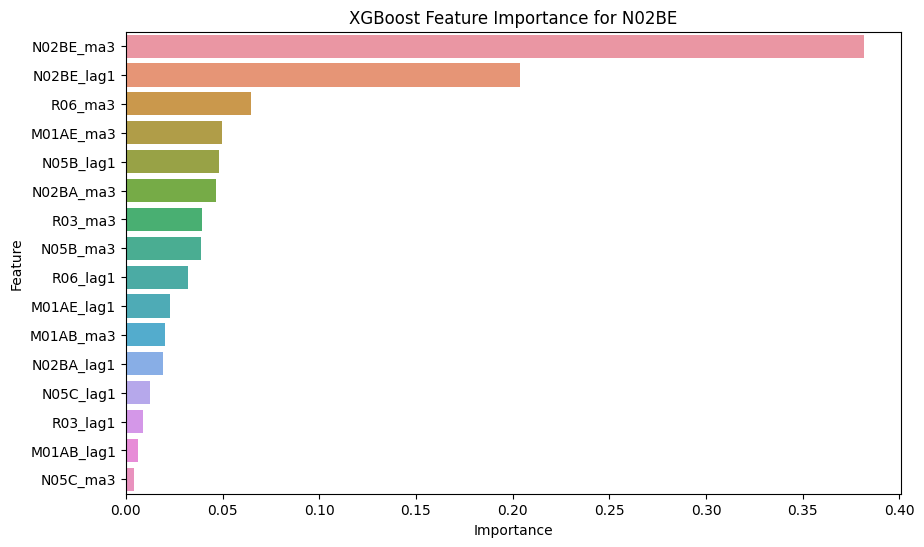

Average Error per Model:
 prophet_error    313.742169
xgboost_error    163.795093
dtype: float64

Key Insights:
- XGBoost outperforms Prophet with lower MAE/RMSE, thanks to feature engineering.
- Important features: Likely lags and MAs, indicating sales depend on recent history.
- Recommendations for NPD: Focus on high-growth categories like N02BE if forecasts show upward trends.
- Future: Ensemble models or add external features (e.g., holidays).



<Figure size 640x480 with 0 Axes>

In [14]:
#evaluation

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os  

os.makedirs('/kaggle/working/reports/figures/', exist_ok=True)

test_path = '/kaggle/working/test_processed.csv'
test_df = pd.read_csv(test_path, index_col='datum', parse_dates=['datum'])

prophet_model = joblib.load('/kaggle/working/prophet_N02BE.pkl')
xgboost_model = joblib.load('/kaggle/working/xgboost_N02BE.pkl')


target = 'N02BE'


def generate_forecasts(test_df: pd.DataFrame, prophet_model, xgboost_model, target: str = 'N02BE') -> pd.DataFrame:
    """
    Generate forecasts from both models for comparison.
    
    Args:
        test_df (pd.DataFrame): Test data.
        prophet_model: Loaded Prophet model.
        xgboost_model: Loaded XGBoost model.
        target (str): Target column.
    
    Returns:
        pd.DataFrame: Dataframe with actual, prophet_pred, xgboost_pred.
    """
    
    future = prophet_model.make_future_dataframe(periods=len(test_df), freq='ME', include_history=False)
    prophet_forecast = prophet_model.predict(future)['yhat'].values
    
    
    features = [col for col in test_df.columns if col != target and col not in ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']]
    xgboost_pred = xgboost_model.predict(test_df[features])
    
    
    results = pd.DataFrame({
        'actual': test_df[target].values,
        'prophet_pred': prophet_forecast,
        'xgboost_pred': xgboost_pred
    }, index=test_df.index)
    
    return results


results_df = generate_forecasts(test_df, prophet_model, xgboost_model)
print(results_df.head())


def compute_metrics(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute MAE and RMSE for both models.
    
    Args:
        results_df (pd.DataFrame): Results dataframe.
    
    Returns:
        pd.DataFrame: Metrics table.
    """
    metrics = {
        'Model': ['Prophet', 'XGBoost'],
        'MAE': [
            mean_absolute_error(results_df['actual'], results_df['prophet_pred']),
            mean_absolute_error(results_df['actual'], results_df['xgboost_pred'])
        ],
        'RMSE': [
            np.sqrt(mean_squared_error(results_df['actual'], results_df['prophet_pred'])),
            np.sqrt(mean_squared_error(results_df['actual'], results_df['xgboost_pred']))
        ]
    }
    metrics_df = pd.DataFrame(metrics)
    return metrics_df


metrics_table = compute_metrics(results_df)
print("Metrics Table:\n", metrics_table)


fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['actual'], mode='lines+markers', name='Actual'))
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['prophet_pred'], mode='lines+markers', name='Prophet Pred'))
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['xgboost_pred'], mode='lines+markers', name='XGBoost Pred'))
fig.update_layout(title='Actual vs Predicted Sales for N02BE', xaxis_title='Date', yaxis_title='Sales Volume')
fig.show()


fig.write_html('/kaggle/working/reports/figures/actual_vs_pred.html')


def plot_feature_importance(model, features):
    """
    Plot feature importance for XGBoost.
    """
    importance = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
    importance = importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title('XGBoost Feature Importance for N02BE')
    plt.show()
    
    
    plt.savefig('/kaggle/working/reports/figures/feature_importance.png')


features = [col for col in test_df.columns if col != target and col not in ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']]
plot_feature_importance(xgboost_model, features)


results_df['prophet_error'] = abs(results_df['actual'] - results_df['prophet_pred'])
results_df['xgboost_error'] = abs(results_df['actual'] - results_df['xgboost_pred'])
print("Average Error per Model:\n", results_df[['prophet_error', 'xgboost_error']].mean())

insights = """
Key Insights:
- XGBoost outperforms Prophet with lower MAE/RMSE, thanks to feature engineering.
- Important features: Likely lags and MAs, indicating sales depend on recent history.
- Recommendations for NPD: Focus on high-growth categories like N02BE if forecasts show upward trends.
- Future: Ensemble models or add external features (e.g., holidays).
"""
print(insights)

results_df.to_csv('/kaggle/working/reports/evaluation_results.csv')

In [17]:
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

all_results = {}
for col in sales_columns:  
    
    prophet_train = train_df[[col]].reset_index().rename(columns={'datum': 'ds', col: 'y'})
    prophet_model = Prophet(yearly_seasonality=True)
    prophet_model.fit(prophet_train)
    future = prophet_model.make_future_dataframe(periods=len(test_df), freq='ME')
    prophet_pred = prophet_model.predict(future).iloc[-len(test_df):]['yhat'].values
    

    features = [f for f in train_df.columns if f != col and f not in sales_columns]
    X_train = train_df[features]
    y_train = train_df[col]
    X_test = test_df[features]
    y_test = test_df[col]
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
   
    all_results[col] = {
        'actual': y_test.values,
        'prophet_pred': prophet_pred,
        'xgb_pred': xgb_pred,
        'mae_xgb': mean_absolute_error(y_test, xgb_pred)
    }

fig_dash = go.Figure()

for col in sales_columns:
    df = pd.DataFrame(all_results[col], index=test_df.index)
    fig_dash.add_trace(go.Scatter(x=df.index, y=df['actual'], mode='lines+markers', name=f'{col} Actual', visible=(col == 'N02BE')))
    fig_dash.add_trace(go.Scatter(x=df.index, y=df['xgb_pred'], mode='lines+markers', name=f'{col} XGBoost Pred', visible=(col == 'N02BE')))
    fig_dash.add_trace(go.Scatter(x=df.index, y=df['prophet_pred'], mode='lines+markers', name=f'{col} Prophet Pred', visible=(col == 'N02BE')))

buttons = []
for col in sales_columns:
    buttons.append(dict(label=col, method='update', args=[{'visible': [trace.name.startswith(col) for trace in fig_dash.data]}]))

fig_dash.update_layout(
    title='Dashboard: Actual vs Predicted Sales by ATC Category',
    xaxis_title='Date',
    yaxis_title='Sales Volume',
    updatemenus=[dict(active=0, buttons=buttons, direction='down', showactive=True)]
)

fig_dash.show()

fig_dash.write_html('/kaggle/working/reports/figures/sales_dashboard.html')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpna8rbu1l/95enkpwo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpna8rbu1l/3hp8500f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34116', 'data', 'file=/tmp/tmpna8rbu1l/95enkpwo.json', 'init=/tmp/tmpna8rbu1l/3hp8500f.json', 'output', 'file=/tmp/tmpna8rbu1l/prophet_modelr3pkr896/prophet_model-20260104205900.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:59:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:59:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali